In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
import utils
import cpils

# Load Data

### available datasets: 'adult', 'marketing', 'compas', 'churn', 'fico', 'german', 'wisconsin'

In [4]:
data = utils.get_tabular_dataset('churn', random_state=42)

X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

idx_num_cat = [list(d.values()) for i,d in data['features_map'].items()]
numeric_idx = [idx for idx,f in enumerate(data['feature_names']) if f in data['numeric_columns']]

# Train Black-Box

In [5]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=60, reg_lambda=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=36,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=3, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       570
           1       0.90      0.72      0.80        97

    accuracy                           0.95       667
   macro avg       0.93      0.85      0.88       667
weighted avg       0.95      0.95      0.95       667



# Learn Latent Space

In [7]:
latent = cpils.CP_ILS(clf_xgb.predict, clf_xgb.predict_proba, latent_dim=2, early_stopping=5)

In [8]:
losses = latent.fit((X_train.values, X_test.values), idx_num_cat, seed=42)

Epoch: 122 Train Loss 0.00007 Test Loss 0.00016 Early Stopping 5


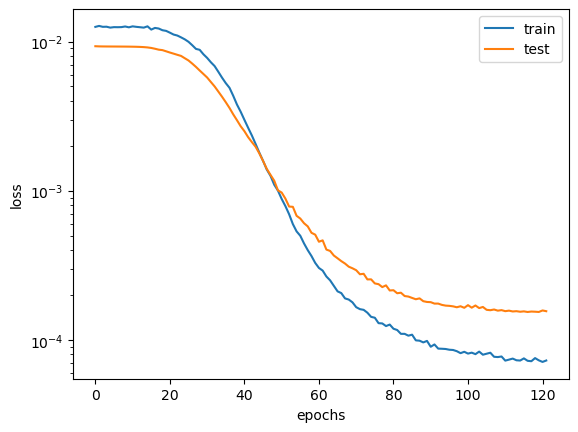

In [9]:
plt.plot(losses[0], label='train')
plt.plot(losses[1], label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()

In [10]:
W_train, Z_train = latent.transform(X_train)

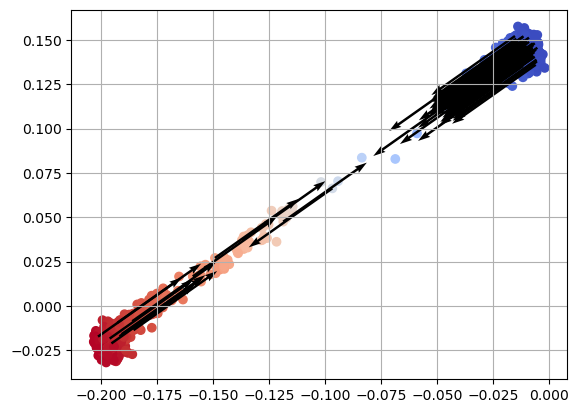

In [11]:
plt.scatter(Z_train[:,0], Z_train[:,1], c=latent.y_train_bb, cmap='coolwarm')
for idx in np.random.choice(Z_train.shape[0], 100, replace=False):
    w = W_train.copy()
    y_contrib = w[:,-1]/np.linalg.norm(w[:,-1])
    if latent.y_train_bb[idx]>0.5:
        y_contrib *=-1
    plt.quiver(Z_train[idx,0], Z_train[idx,1],
                y_contrib[0], y_contrib[1], angles='xy', scale_units='xy', width=5*1e-3, scale=20)
plt.grid()

# Counterfactuals

In [12]:
# indices of features to change
change_f =  list(range(X_train.shape[1]))

# number of features to change
max_f = 6

idx = 0
instances = X_test.iloc[idx:idx+5,:].copy()

cfs_df = latent.get_counterfactuals(instances, change_f, max_f, 
                    max_steps=50, n_cfs=-1, n_feats_sampled=10, topn_to_check=10, seed=42)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.34s/it]


In [13]:
cfs_df.head(10)

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,state=AK,state=AL,state=AR,state=AZ,state=CA,state=CO,state=CT,state=DC,state=DE,state=FL,state=GA,state=HI,state=IA,state=ID,state=IL,state=IN,state=KS,state=KY,state=LA,state=MA,state=MD,state=ME,state=MI,state=MN,state=MO,state=MS,state=MT,state=NC,state=ND,state=NE,state=NH,state=NJ,state=NM,state=NV,state=NY,state=OH,state=OK,state=OR,state=PA,state=RI,state=SC,state=SD,state=TN,state=TX,state=UT,state=VA,state=VT,state=WA,state=WI,state=WV,state=WY,international plan=no,international plan=yes,voice mail plan=no,voice mail plan=yes
601,62.000000,415.0,0.000000,159.7,86.0,27.15,197.500000,76.000000,16.79,121.6,105.000000,5.47,0.0,6.0,3.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
601,62.000000,415.0,0.000000,159.7,86.0,27.15,197.500000,76.000000,16.79,121.6,105.000000,5.47,13.9,6.0,3.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
601,62.000000,415.0,18.776718,350.8,86.0,27.15,197.500000,76.000000,16.79,121.6,105.000000,5.47,13.9,6.0,3.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
601,62.000000,415.0,19.126025,350.8,86.0,0.00,104.340255,144.652286,16.79,121.6,105.000000,5.47,13.9,6.0,3.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
601,62.000000,415.0,31.349290,350.8,86.0,27.15,215.452687,170.000000,16.79,121.6,129.647865,5.47,13.9,6.0,4.850123,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2050,121.000000,408.0,0.000000,213.2,79.0,36.24,120.700000,116.000000,10.26,395.0,175.000000,11.00,7.5,4.0,2.030000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2050,121.000000,408.0,0.000000,213.2,165.0,36.24,120.700000,116.000000,10.26,244.4,102.000000,1.04,7.5,4.0,2.030000,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2050,121.000000,408.0,0.000000,213.2,79.0,36.24,120.700000,116.000000,10.26,244.4,175.000000,11.00,7.5,4.0,2.030000,6.420027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2050,157.049819,408.0,0.000000,0.0,79.0,36.24,120.700000,116.000000,10.26,244.4,102.000000,11.00,7.5,4.0,2.030000,3.890146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2050,185.286163,408.0,51.000000,213.2,79.0,36.24,120.700000,116.000000,10.26,244.4

# Prototypes

In [14]:
idx = 0
instances = X_test.iloc[idx:idx+5,:].copy()

n_proto = 20

global_proto_df, nearest_proto_df = latent.get_prototypes(instances, n_proto, seed=42)

In [15]:
global_proto_df

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,state=AK,state=AL,state=AR,state=AZ,state=CA,state=CO,state=CT,state=DC,state=DE,state=FL,state=GA,state=HI,state=IA,state=ID,state=IL,state=IN,state=KS,state=KY,state=LA,state=MA,state=MD,state=ME,state=MI,state=MN,state=MO,state=MS,state=MT,state=NC,state=ND,state=NE,state=NH,state=NJ,state=NM,state=NV,state=NY,state=OH,state=OK,state=OR,state=PA,state=RI,state=SC,state=SD,state=TN,state=TX,state=UT,state=VA,state=VT,state=WA,state=WI,state=WV,state=WY,international plan=no,international plan=yes,voice mail plan=no,voice mail plan=yes
0,130.0,510.0,0.0,139.1,72.0,23.65,246.0,112.0,20.91,207.2,121.0,9.32,11.4,9.0,3.08,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,70.0,415.0,0.0,197.3,91.0,33.54,305.8,81.0,25.99,171.0,105.0,7.69,6.7,6.0,1.81,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,102.0,510.0,0.0,195.7,116.0,33.27,209.1,87.0,17.77,201.1,73.0,9.05,8.3,3.0,2.24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,108.0,415.0,35.0,169.8,136.0,28.87,173.7,101.0,14.76,214.6,105.0,9.66,9.5,7.0,2.57,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,130.0,408.0,0.0,252.0,101.0,42.84,170.2,105.0,14.47,209.2,64.0,9.41,5.7,5.0,1.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,124.0,415.0,0.0,194.0,103.0,32.98,241.0,116.0,20.49,227.5,153.0,10.24,11.9,5.0,3.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,90.0,415.0,24.0,71.2,82.0,12.10,181.6,103.0,15.44,186.9,111.0,8.41,12.9,1.0,3.48,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,133.0,510.0,0.0,245.8,102.0,41.79,264.7,90.0,22.50,111.7,103.0,5.03,11.2,7.0,3.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,160.0,408.0,0.0,82.7,116.0,14.06,194.6,95.0,16.54,159.0,54.0,7.15,10.9,9.0,2.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
9,115.0,510.0,16.0,133.3,110.0,22.66,185.7,111.0,15.78,161.5,113.0,7.27,5.6,4.0,1.51,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
